In [57]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

import nfp

In [178]:
redox_data = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz').dropna(subset=['ionization energy', 'electron affinity']).reset_index(drop=True)
outliers_ie = pd.read_csv('outliers_ie.csv', index_col=0) #outlier in IE
outliers_ea = pd.read_csv('outliers_ea.csv', index_col=0) #outlier in EA

In [166]:
import sys
sys.path.append('/home/pstjohn/Research/rlmolecule')  # make sure that the repo root is in your python path

from rdkit import Chem
from alphazero.preprocessor import preprocessor

redox_model = tf.keras.models.load_model(
    '/projects/rlmolecule/pstjohn/models/20210214_redox/',
    compile=False)

embedding_model = tf.keras.Model(redox_model.inputs, redox_model.layers[-1].input)

In [167]:
def dataset(smiles):
    return tf.data.Dataset.from_generator(
        lambda: (preprocessor.construct_feature_matrices(Chem.MolFromSmiles(smiles), train=False)
                 for smiles in smiles),
        output_types=preprocessor.output_types,
        output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)
    
train_data_embeddings = embedding_model.predict(dataset(redox_data.smiles), verbose=1)

    173/Unknown - 11s 66ms/step

RDKit WARNING: [14:34:03] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [14:34:04]   BondStereo set to STEREONONE and single bond directions set to NONE.


    370/Unknown - 25s 67ms/step

RDKit WARNING: [14:34:17] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [14:34:17]   BondStereo set to STEREONONE and single bond directions set to NONE.


370/370 [==============================] - 25s 67ms/step


33

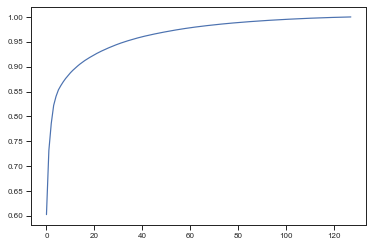

In [168]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA().fit(train_data_embeddings)

# This shows the dimensionality of the latent space. 95% of the variation in the latent space
# is explained by only taking the first 30 PCA dimensions. 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
np.where(np.cumsum(pca.explained_variance_ratio_) > .95)[0][0]

In [169]:
pipe = Pipeline(steps=(
    ('PCA', PCA(n_components=30)),  # Here, from above, we compress to a dimensionality of 30 to save time
    ('NearestNeighbors', NearestNeighbors(n_neighbors=5))
))

pipe.fit(train_data_embeddings)

def pipe_kneighbors(pipe, X):
    """Evalutate the neighbors model for new embeddings to find the nearest items in the training data"""
    Xt = pipe.steps[0][-1].transform(X)
    return pipe.steps[-1][-1].kneighbors(Xt)

In [180]:
outliers_ie_embeddings = embedding_model.predict(dataset(outliers_ie.smiles), verbose=1)
outliers_ea_embeddings = embedding_model.predict(dataset(outliers_ea.smiles), verbose=1)

ie_distances, ie_indices = pipe_kneighbors(pipe, outliers_ie_embeddings)
ea_distances, ea_indices = pipe_kneighbors(pipe, outliers_ea_embeddings)

1/1 [==============================] - 0s 6ms/step


In [181]:
# import for drawing
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit
print(rdkit.__version__)

2020.09.4


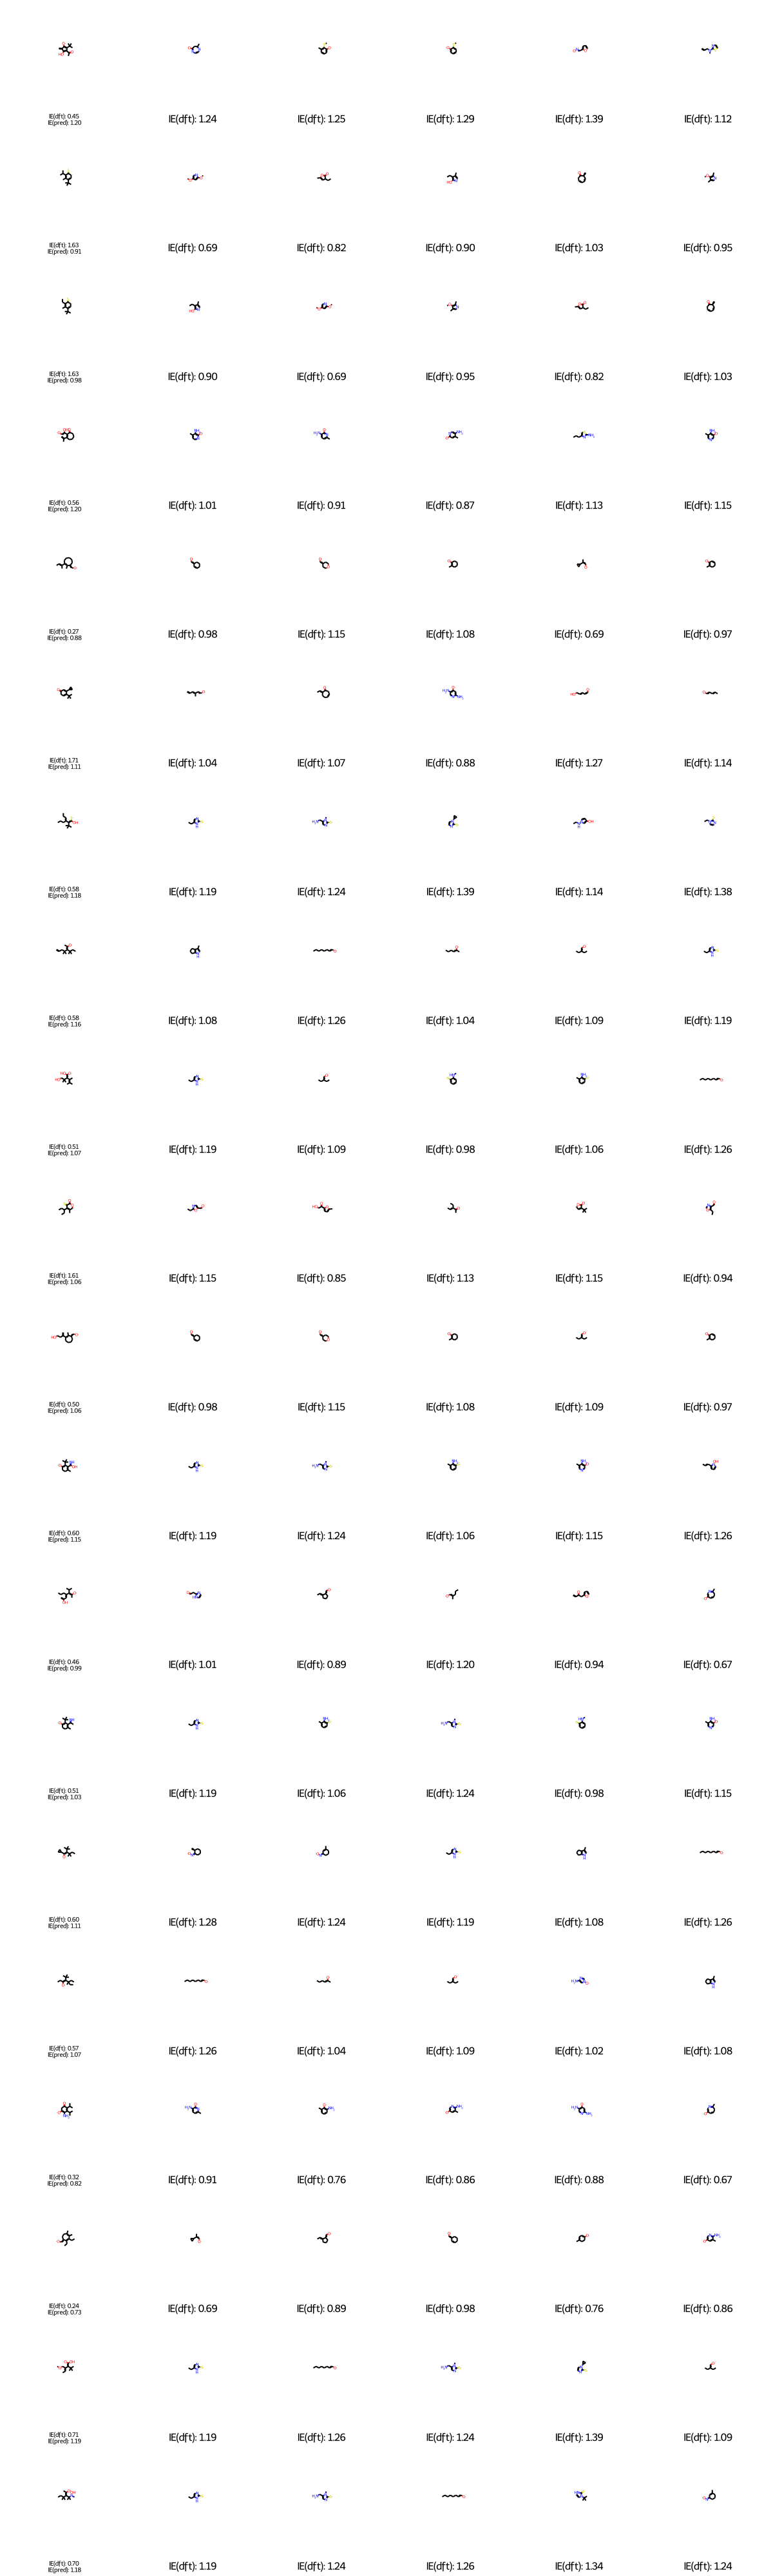

In [179]:
mols_ie = []
text_ie = []

for (_, row), row_indices in zip(outliers_ie.iterrows(), ie_indices):
    mols_ie += [Chem.MolFromSmiles(row.smiles)]
    text_ie += [f"IE(dft): {row['ionization energy']:.2f}\n IE(pred): {row['pred ionization energy']:.2f}"]
    
    for _, data_row in redox_data.reindex(row_indices).iterrows():
        mols_ie += [Chem.MolFromSmiles(data_row.smiles)]
        text_ie += [f"IE(dft): {data_row['ionization energy']:.2f}"]
        
Chem.Draw.MolsToGridImage(mols_ie, molsPerRow=6, maxMols=120, legends=text_ie)

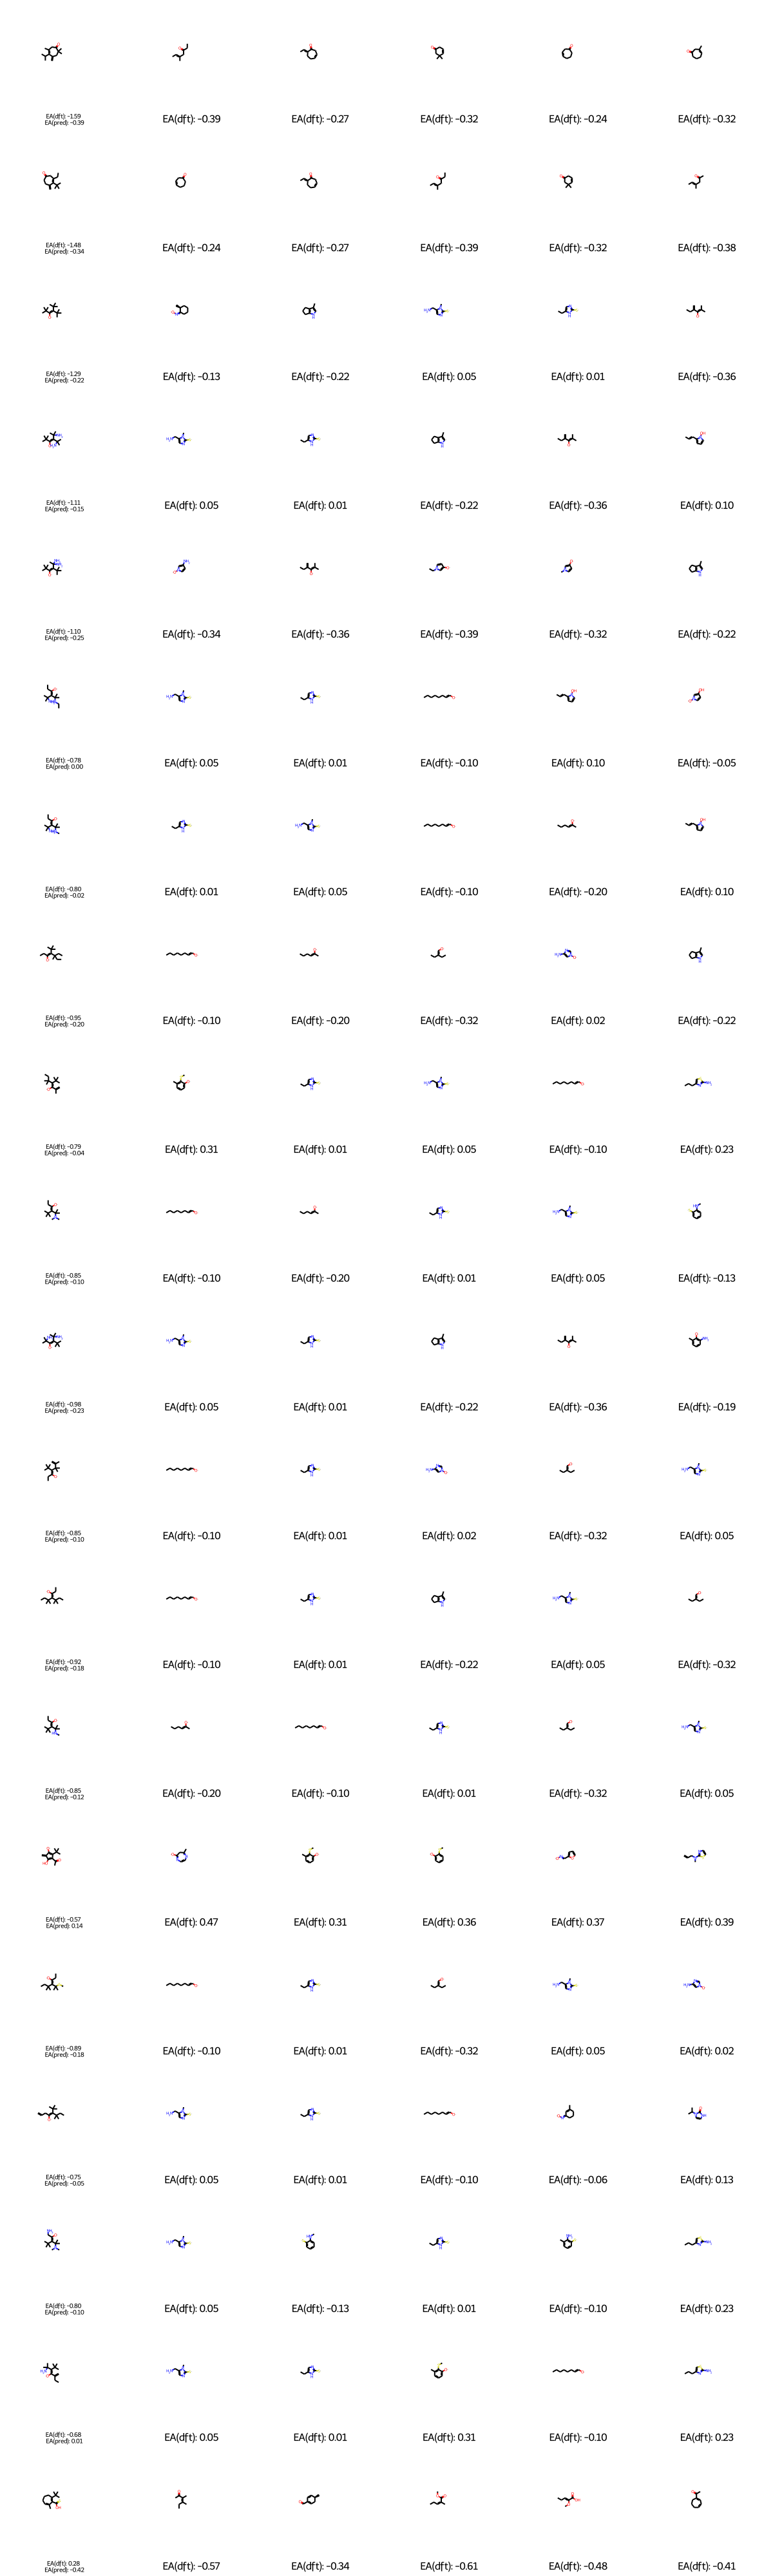

In [183]:
mols_ea = []
text_ea = []

for (_, row), row_indices in zip(outliers_ea.iterrows(), ea_indices):
    mols_ea += [Chem.MolFromSmiles(row.smiles)]
    text_ea += [f"EA(dft): {row['electron affinity']:.2f}\n EA(pred): {row['pred electron affinity']:.2f}"]
    
    for _, data_row in redox_data.reindex(row_indices).iterrows():
        mols_ea += [Chem.MolFromSmiles(data_row.smiles)]
        text_ea += [f"EA(dft): {data_row['electron affinity']:.2f}"]
        
Chem.Draw.MolsToGridImage(mols_ea, molsPerRow=6, maxMols=120, legends=text_ea)